# Create Custom NEID CCFs

In [125]:
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import constants
from pathlib import Path

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import time
import scipy.interpolate as interp

from tamar.tools.settings import PlotDir, CsvDir, ImgDir
# package import and directory handling
#-------------------------------------
# sort out paths
local_path = Path.home()
file_path = os.path.join(os.path.join(local_path,'Google Drive'),'NEID_DEV')
prv_package_path = os.path.join(file_path,'python_packages_prv')
sys.path.append(prv_package_path) # add path to package search
import NEIDcode



In [126]:
# plotting preamble
#-----------------------------------------
%matplotlib inline

# sort out paths
plot_path = PlotDir.MPL
plot_style = os.path.join(plot_path, 'timeseries.mplstyle')
plt.style.use(plot_style)
plt.rcParams['figure.figsize'] = [10,7]
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'  # changes only the mathcal subfamily
#-----------------------------------------

### Provide list of files to process

In [127]:
# get list of neid days
neid_days = os.listdir(CsvDir.NEID_SOLAR)

# choose date to use
date = '20210207'

# get files list
file = os.path.join(CsvDir.NEID_SOLAR, date, 'level2', date)
files = [i for i in glob.glob(os.path.join(file, '*.fits'))]

nfiles = len(files)
print('There were {} files found for processing.'.format(nfiles))

There were 18 files found for processing.


### Set up configuration for custom CCF -- this is to make the CCF function interface as closely as possible to the pipeline version


In [128]:
config = {
    'velocity_min': -100, # km/s minumum velocity at which to compute the CCF
    'velocity_max': 101, # km/s  minumum velocity at which to compute the CCF
    'velocity_step': 0.25, # km/s velocity step size at which to compute the CCF
    'qrv': 0, # km/s systemic velocity of target star
    'mask_name': 'G2_espresso.txt', # name of mask file containing line list
    'mask_half_width': 0.5, # km/s width of binary mask (same for all lines)
    'mask_environment': 'air', # air or vac wavelengths for mask lines
    'ordmin': 57, # min echelle order number for which to compute CCF (reddest)
    'ordmax': 169, # max echelle order number for which to compute CCF (bluest)
    'bluest_order': 173, # bluest order currently extracted (don't change this)
    'resolution': 120000, # spectral resolution of instrument, lambda / delta_lambda
    'sampling': 5, # approximate pixel sampling of resolution element (pixels, FWHM)
    'velocity_half_range_to_fit': 20, # half width of velocity window for which to fit CCF and derive RV (subset of fill velocity range)
    'clip_edge_pixels': 500 # toss out pixels towards the edge of the array
}

### Cascade configuration to parameters

In [129]:
# set up some useful constants
LIGHTSPEED = constants.c/1000  # Speed of light in km/s
minzb = -30/LIGHTSPEED
maxzb = +30/LIGHTSPEED

# Set up velocity loop
velocity_loop = np.arange(config['velocity_min'], config['velocity_max'], config['velocity_step']) + config['qrv']
velsize = len(velocity_loop)

# total number of extracted orders
orders = 122  # hard coded for NEID
ccfs_fortran = np.zeros([nfiles,orders,velsize])
ccfs_pipeline = np.zeros([nfiles,orders,velsize])
rv_order = np.zeros([nfiles,orders])

# generate mask object based on config parameters
mask = NEIDcode.Mask(config['mask_name'], config['mask_half_width'], config['mask_environment'])

### Get Free Spectral Range (FSR) Mask 

In [130]:
# apply free-spectral-range mask?
fsr_mask = None
#fst_mask = fits.open(os.path.join('.','masks/neidMaster_FSR_Mask20210218_v002.fits'))[0].data

## FORTRAN Version

In [131]:
start_time = time.time()

# for each file, loop through each order and compute CCF
for n, f in enumerate(files):
    a = fits.open(f)
    flux = a['SCIFLUX'].data
    wave = a['SCIWAVE'].data
    head = a[0].header
    ccfhead = a['CCFS'].header
    ccfwt = np.zeros(122)
    
    # switch between order index and echelle order, then loop
    for trueorder in tqdm( range(config['ordmin'], config['ordmax']+1,1)):
        zb = head['SSBZ%03i'%trueorder]  
        berv = head['SSBRV%03i'%trueorder]
        raworder = config['bluest_order'] - trueorder
        ccfwt[raworder] = ccfhead['CCFWT%03i'%trueorder]
        
        # You have to remove NaNs ahead of passing spectrum to Fortran code
        nanfree = NEIDcode.remove_nans(flux[raworder,:], method='linear') 
        spectrum = nanfree[0]

        if fsr_mask is None:
            # Number of blaze edge pixels to clip on either side of order
            pix_start = config['clip_edge_pixels']
            pix_end = np.shape(flux)[1] - config['clip_edge_pixels']
        else:
            if np.sum(np.logical_not(fsr_mask[raworder,:])) == 0:
                continue
            else:
                pix_start = np.min(np.argwhere(np.logical_not(fsr_mask[raworder,:])))
                pix_end = np.max(np.argwhere(np.logical_not(fsr_mask[raworder,:])))            
            
        dummy_line_start = mask.start * ((1.0 + (velocity_loop[0] / LIGHTSPEED)) / (1.0 + maxzb))
        dummy_line_end   = mask.end * ((1.0 + (velocity_loop[-1] / LIGHTSPEED)) / (1.0 + minzb))
        try:
            line_index       = np.where((dummy_line_start > np.min(wave[raworder,pix_start:pix_end])) & 
                                        (dummy_line_end < np.max(wave[raworder,pix_start:pix_end])))[0]
        except TypeError:
            line_index=[]
            
            
        sn = np.ones(len(flux[raworder,pix_start:pix_end]))
        if not len(line_index) == 0:
            for k in range(len(velocity_loop)):

                ccfs_fortran[n,raworder,k] = NEIDcode.CCF_3d.ccf(mask.start[line_index], mask.end[line_index],
                                wave[raworder,pix_start:pix_end],
                                spectrum[pix_start:pix_end],
                                mask.weight[line_index],
                                sn, # Additional SNR scaling factor, just setting to 1
                                velocity_loop[k],
                                berv,
                                0.) # Additional velocity that is not needed

        else:
            ccfs_fortran[n, raworder, :] = np.zeros(len(velocity_loop))
            

end_time = time.time()
elapsed_time = end_time - start_time
print("Finished processing {} files in {} seconds.".format( nfiles, elapsed_time))

100%|██████████| 113/113 [00:03<00:00, 37.47it/s]

Finished processing 18 files in 44.24324369430542 seconds.


# Do the same for active sun date

In [132]:
# choose date to use
date = '20210117'

# get files list
file = os.path.join(CsvDir.NEID_SOLAR, date, 'level2', date)
files = [i for i in glob.glob(os.path.join(file, '*.fits'))]

nfiles = len(files)
print('There were {} files found for processing.'.format(nfiles))

There were 19 files found for processing.


### Set up configuration for custom CCF -- this is to make the CCF function interface as closely as possible to the pipeline version


In [133]:
config = {
    'velocity_min': -100, # km/s minumum velocity at which to compute the CCF
    'velocity_max': 101, # km/s  minumum velocity at which to compute the CCF
    'velocity_step': 0.25, # km/s velocity step size at which to compute the CCF
    'qrv': -33.165, # km/s systemic velocity of target star
    'mask_name': 'G2_espresso.txt', # name of mask file containing line list
    'mask_half_width': 0.5, # km/s width of binary mask (same for all lines)
    'mask_environment': 'air', # air or vac wavelengths for mask lines
    'ordmin': 57, # min echelle order number for which to compute CCF (reddest)
    'ordmax': 169, # max echelle order number for which to compute CCF (bluest)
    'bluest_order': 173, # bluest order currently extracted (don't change this)
    'resolution': 120000, # spectral resolution of instrument, lambda / delta_lambda
    'sampling': 5, # approximate pixel sampling of resolution element (pixels, FWHM)
    'velocity_half_range_to_fit': 20, # half width of velocity window for which to fit CCF and derive RV (subset of fill velocity range)
    'clip_edge_pixels': 500 # toss out pixels towards the edge of the array
}

### Cascade configuration to parameters

In [134]:
# set up some useful constants
LIGHTSPEED = constants.c/1000  # Speed of light in km/s
minzb = -30/LIGHTSPEED
maxzb = +30/LIGHTSPEED

# Set up velocity loop
velocity_loop = np.arange(config['velocity_min'], config['velocity_max'], config['velocity_step']) + config['qrv']
velsize = len(velocity_loop)

# total number of extracted orders
orders = 122  # hard coded for NEID
active_ccfs = np.zeros([nfiles, orders, velsize])
ccfs_pipeline = np.zeros([nfiles, orders, velsize])
rv_order = np.zeros([nfiles,orders])

# generate mask object based on config parameters
mask = NEIDcode.Mask(config['mask_name'], config['mask_half_width'], config['mask_environment'])

### Get Free Spectral Range (FSR) Mask

In [135]:
# apply free-spectral-range mask?
fsr_mask = None
#fst_mask = fits.open(os.path.join('.','masks/neidMaster_FSR_Mask20210218_v002.fits'))[0].data

## FORTRAN Version

In [136]:
start_time = time.time()

# for each file, loop through each order and compute CCF
for n, f in enumerate(files):
    a = fits.open(f)
    flux = a['SCIFLUX'].data
    wave = a['SCIWAVE'].data
    head = a[0].header
    ccfhead = a['CCFS'].header
    ccfwt = np.zeros(122)

    # switch between order index and echelle order, then loop
    for trueorder in tqdm(range(config['ordmin'], config['ordmax']+1,1)):
        zb = head['SSBZ%03i'%trueorder]
        berv = head['SSBRV%03i'%trueorder]
        raworder = config['bluest_order'] - trueorder
        ccfwt[raworder] = ccfhead['CCFWT%03i'%trueorder]

        # You have to remove NaNs ahead of passing spectrum to Fortran code
        nanfree = NEIDcode.remove_nans(flux[raworder,:], method='linear')
        spectrum = nanfree[0]

        if fsr_mask is None:
            # Number of blaze edge pixels to clip on either side of order
            pix_start = config['clip_edge_pixels']
            pix_end = np.shape(flux)[1] - config['clip_edge_pixels']
        else:
            if np.sum(np.logical_not(fsr_mask[raworder,:])) == 0:
                continue
            else:
                pix_start = np.min(np.argwhere(np.logical_not(fsr_mask[raworder,:])))
                pix_end = np.max(np.argwhere(np.logical_not(fsr_mask[raworder,:])))

        dummy_line_start = mask.start * ((1.0 + (velocity_loop[0] / LIGHTSPEED)) / (1.0 + maxzb))
        dummy_line_end   = mask.end * ((1.0 + (velocity_loop[-1] / LIGHTSPEED)) / (1.0 + minzb))
        try:
            line_index       = np.where((dummy_line_start > np.min(wave[raworder,pix_start:pix_end])) &
                                        (dummy_line_end < np.max(wave[raworder,pix_start:pix_end])))[0]
        except TypeError:
            line_index=[]


        sn = np.ones(len(flux[raworder,pix_start:pix_end]))
        if not len(line_index) == 0:
            for k in range(len(velocity_loop)):

                active_ccfs[n,raworder,k] = NEIDcode.CCF_3d.ccf(mask.start[line_index], mask.end[line_index],
                                wave[raworder,pix_start:pix_end],
                                spectrum[pix_start:pix_end],
                                mask.weight[line_index],
                                sn, # Additional SNR scaling factor, just setting to 1
                                velocity_loop[k],
                                berv,
                                0.) # Additional velocity that is not needed

        else:
            active_ccfs[n, raworder, :] = np.zeros(len(velocity_loop))


end_time = time.time()
elapsed_time = end_time - start_time
print("Finished processing {} files in {} seconds.".format( nfiles, elapsed_time))


100%|██████████| 113/113 [00:02<00:00, 41.84it/s]

Finished processing 19 files in 48.700236082077026 seconds.


# Plot stuff yay


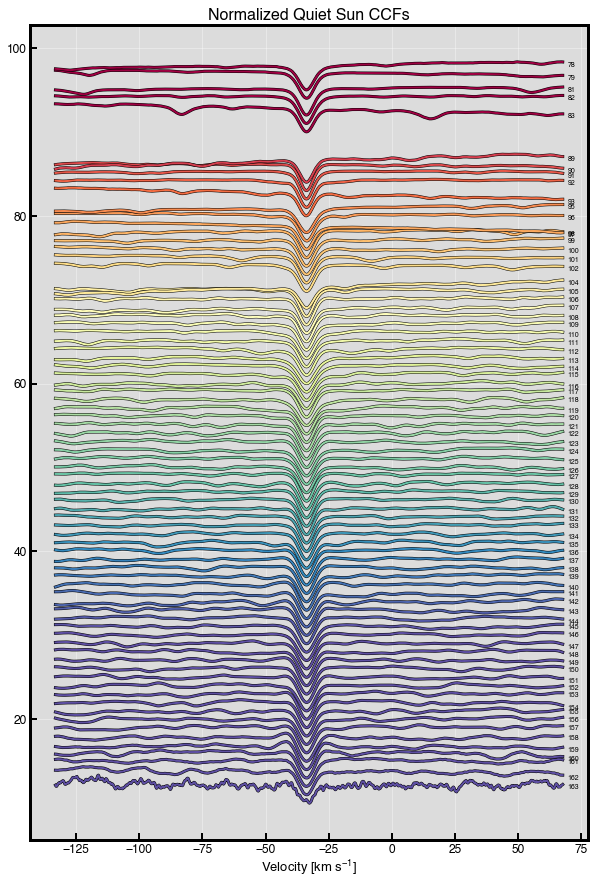

<Figure size 720x1080 with 0 Axes>

In [137]:
# quiet sun

i = 12

# get wavelength array
# get ccf header
ccf_header = fits.getheader(files[i], 'CCFS')

# get wavelength information
wvl = fits.getdata(files[i], 'SCI' + 'WAVE') / 10.

# set some plotting parameters
Col = plt.get_cmap('Spectral')
plt.rcParams['figure.figsize'] = [10, 15]

# ignore division error
np.seterr(divide='ignore', invalid='ignore')

# plot each order cross-correlation function
for ind, order in enumerate(range(122)):
    wvl_norm = 1. - (np.mean(wvl[ind,:]) - 420.) / (720. - 420.)
    ccf = ccfs_fortran[i, ind,:]
    ccf_scaled = (ccf - np.amin(ccf))
    ccf_scaled /= max(ccf_scaled) * 0.3
    ccf_scaled += ind
    plt.plot(velocity_loop, ccf_scaled, c='black', linewidth=3)
    plt.plot(velocity_loop, ccf_scaled, c=Col(wvl_norm), lw=2.)
    plt.annotate(str(173 - ind), (max(velocity_loop) + 2., ccf_scaled[-1] - 0.5), fontsize=7)

plt.title('Normalized Quiet Sun CCFs')
plt.xlabel('Velocity [km s$^{-1}$]')
plt.show()
plt.savefig(os.path.join(ImgDir.CCF_IMG, 'fortran', 'quiet_sun.png'))

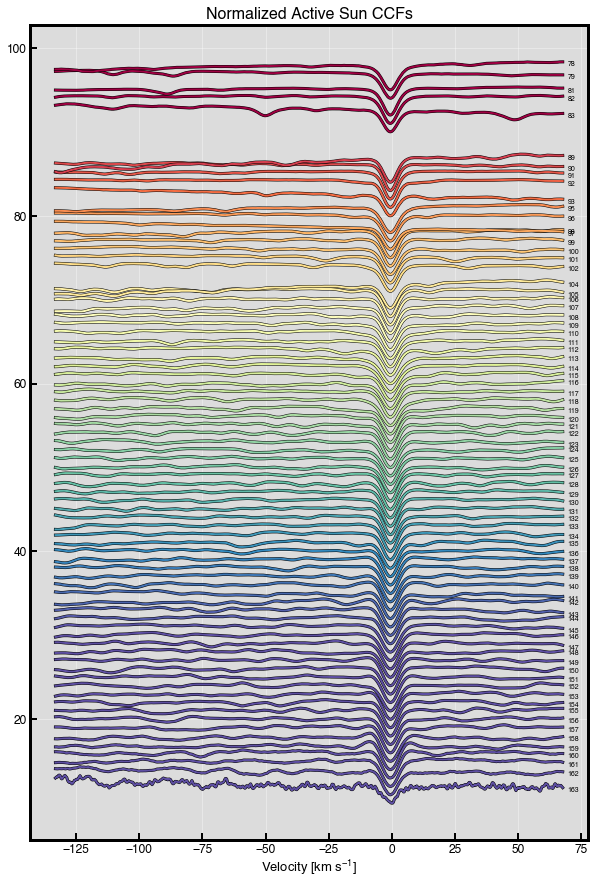

<Figure size 720x1080 with 0 Axes>

In [138]:
# active sun

i = 12


# get wavelength information
wvl = fits.getdata(files[i], 'SCI' + 'WAVE') / 10.

# set some plotting parameters
Col = plt.get_cmap('Spectral')
plt.rcParams['figure.figsize'] = [10, 15]

# ignore division error
np.seterr(divide='ignore', invalid='ignore')

# plot each order cross-correlation function
for ind, order in enumerate(range(122)):
    wvl_norm = 1. - (np.mean(wvl[ind,:]) - 420.) / (720. - 420.)
    ccf = active_ccfs[i, ind,:]
    ccf_scaled = (ccf - np.amin(ccf))
    ccf_scaled /= max(ccf_scaled) * 0.3
    ccf_scaled += ind
    plt.plot(velocity_loop, ccf_scaled, c='black', linewidth=3)
    plt.plot(velocity_loop, ccf_scaled, c=Col(wvl_norm), lw=2.)
    plt.annotate(str(173 - ind), (max(velocity_loop) + 2., ccf_scaled[-1] - 0.5), fontsize=7)

plt.title('Normalized Active Sun CCFs')
plt.xlabel('Velocity [km s$^{-1}$]')
plt.show()
plt.savefig(os.path.join(ImgDir.CCF_IMG, 'fortran', 'active_sun.png'))

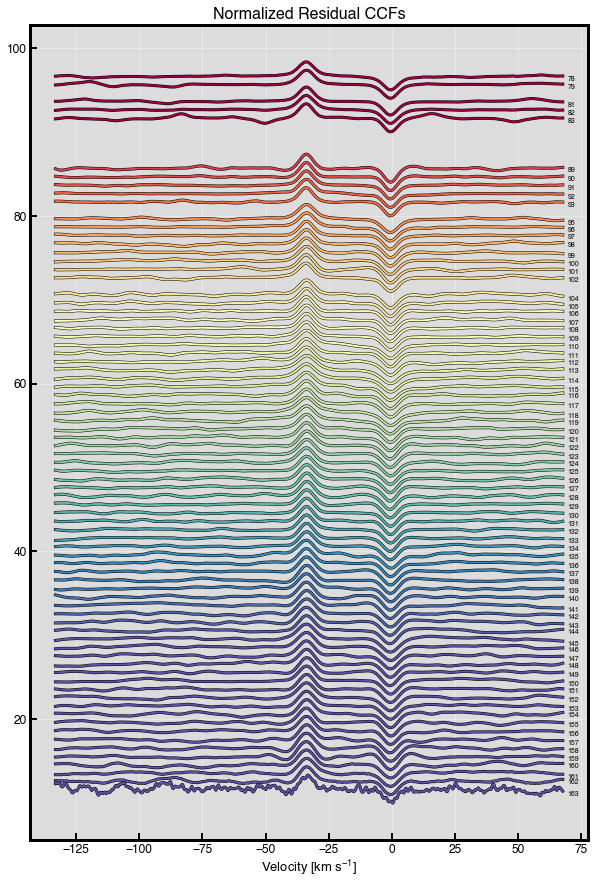

<Figure size 720x1080 with 0 Axes>

In [139]:
# residuals

i = 12

# get wavelength array
# get ccf header
ccf_header = fits.getheader(files[i], 'CCFS')

# get wavelength information
wvl = fits.getdata(files[i], 'SCI' + 'WAVE') / 10.

# set some plotting parameters
Col = plt.get_cmap('Spectral')
plt.rcParams['figure.figsize'] = [10, 15]

# ignore division error
np.seterr(divide='ignore', invalid='ignore')

# plot each order cross-correlation function
for ind, order in enumerate(range(122)):
    wvl_norm = 1. - (np.mean(wvl[ind,:]) - 420.) / (720. - 420.)
    ccf = active_ccfs[i, ind, :] - ccfs_fortran[i, ind, :]
    ccf_scaled = (ccf - np.amin(ccf))
    ccf_scaled /= max(ccf_scaled) * 0.3
    ccf_scaled += ind
    plt.plot(velocity_loop, ccf_scaled, c='black', linewidth=3)
    plt.plot(velocity_loop, ccf_scaled, c=Col(wvl_norm), lw=2.)
    plt.annotate(str(173 - ind), (max(velocity_loop) + 2., ccf_scaled[-1] - 0.5), fontsize=7)

plt.title('Normalized Residual CCFs')
plt.xlabel('Velocity [km s$^{-1}$]')
plt.show()
plt.savefig(os.path.join(ImgDir.CCF_IMG, 'fortran', 'residual_ccfs.png'))


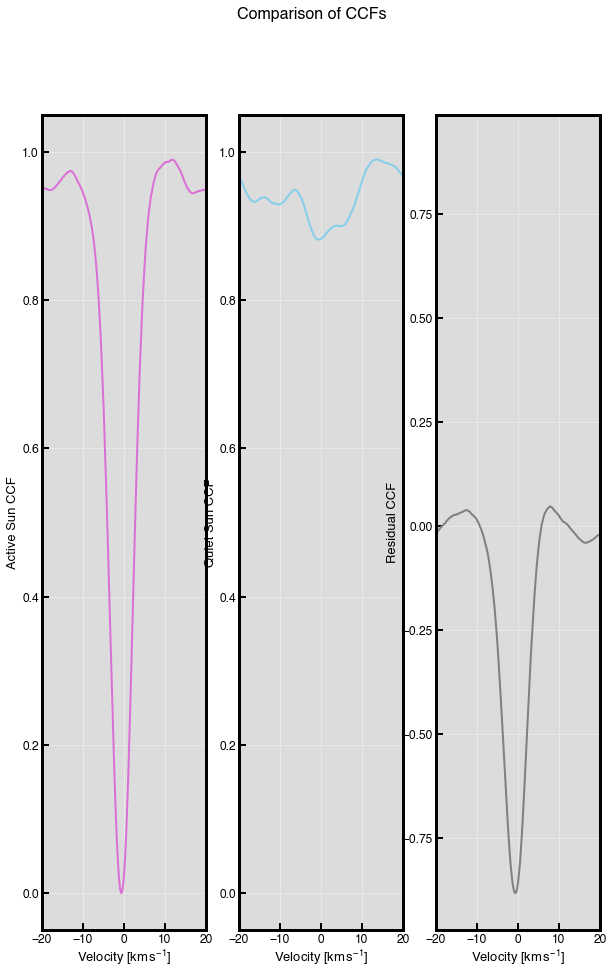

In [140]:
ind = 40

# plot them
fig, axs = plt.subplots(1, 3, sharex='all', gridspec_kw={'hspace': 0.1})
plt.rcParams['figure.figsize'] = [12, 6]
active = (active_ccfs[i, ind, :] - np.amin(active_ccfs[i, ind, :]))
active /= max(active)
quiet = (ccfs_fortran[i, ind, :] - np.amin(ccfs_fortran[i, ind, :]))
quiet /= max(quiet)
residual = active - quiet
axs[0].plot(velocity_loop, active, c='orchid', linewidth=2)
axs[1].plot(velocity_loop, quiet, c='skyblue', linewidth=2)
axs[2].plot(velocity_loop, residual, c='grey', linewidth=2)
axs[0].set_ylabel('Active Sun CCF')
axs[1].set_ylabel('Quiet Sun CCF')
axs[2].set_ylabel('Residual CCF')
axs[0].set_xlabel('Velocity [$km\/s^{-1}$]')
axs[1].set_xlabel('Velocity [$km\/s^{-1}$]')
axs[2].set_xlabel('Velocity [$km\/s^{-1}$]')
plt.xlim(-20, 20)
plt.suptitle('Comparison of CCFs')
fig.align_ylabels(axs)

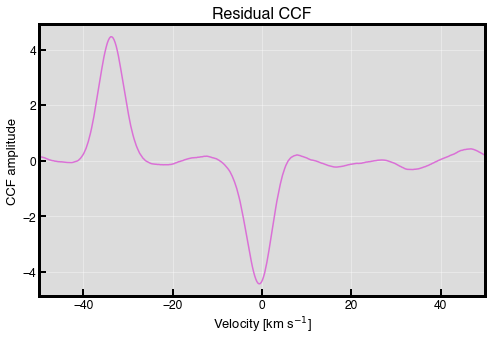

In [141]:
# choose order to plot
oi = 30

# normalize
res_norm = residual
res_norm = (res_norm - np.nanmedian(res_norm))
res_norm /= np.std(res_norm)

# plot example CCF from one order
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(velocity_loop, res_norm,'orchid')
plt.xlabel('Velocity [km s$^\mathcal{-1}$]')
plt.ylabel('CCF amplitude')
plt.title('Residual CCF')
plt.xlim(-50, 50)
plt.show()

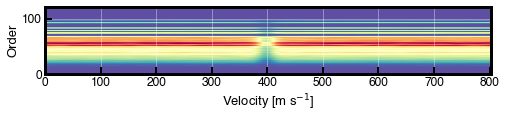

In [142]:
plt.imshow(ccfs_fortran[i, :, :], cmap='Spectral_r')
plt.xlabel('Velocity [m s$^\mathcal{-1}$]')
plt.ylabel('Order')
plt.ylim(0, 121)
plt.show()


